# Crawling State of the Union Adresses from millercenter.org website

In [1]:
# Loading packages

import requests
from bs4 import BeautifulSoup
import os
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
from random import *

In [2]:
### Data Quality Connector class

def ratelimit(dt):
    "A function that handles the rate of your calls."
    time.sleep(dt) # sleep one second.

class Connector():
  def __init__(self,logfile,overwrite_log=False,connector_type='requests',session=False,path2selenium='',n_tries = 5,timeout=30,waiting_time=0.5):
    """This Class implements a method for reliable connection to the internet and monitoring. 
    It handles simple errors due to connection problems, and logs a range of information for basic quality assessments
    
    Keyword arguments:
    logfile -- path to the logfile
    overwrite_log -- bool, defining if logfile should be cleared (rarely the case). 
    connector_type -- use the 'requests' module or the 'selenium'. Will have different since the selenium webdriver does not have a similar response object when using the get method, and monitoring the behavior cannot be automated in the same way.
    session -- requests.session object. For defining custom headers and proxies.
    path2selenium -- str, sets the path to the geckodriver needed when using selenium.
    n_tries -- int, defines the number of retries the *get* method will try to avoid random connection errors.
    timeout -- int, seconds the get request will wait for the server to respond, again to avoid connection errors.
    """
    
    ## Initialization function defining parameters. 
    self.n_tries = n_tries # For avoiding triviel error e.g. connection errors, this defines how many times it will retry.
    self.timeout = timeout # Defining the maximum time to wait for a server to response.
    self.waiting_time = waiting_time # define simple rate_limit parameter.
    ## not implemented here, if you use selenium.
    if connector_type=='selenium':
      assert path2selenium!='', "You need to specify the path to you geckodriver if you want to use Selenium"
      from selenium import webdriver 
      ## HIN download the latest geckodriver here: https://github.com/mozilla/geckodriver/releases

      assert os.path.isfile(path2selenium),'You need to insert a valid path2selenium the path to your geckodriver. You can download the latest geckodriver here: https://github.com/mozilla/geckodriver/releases'
      self.browser = webdriver.Firefox(executable_path=path2selenium) # start the browser with a path to the geckodriver.

    self.connector_type = connector_type # set the connector_type
    
    if session: # set the custom session
      self.session = session
    else:
      self.session = requests.session()
    self.logfilename = logfile # set the logfile path
    ## define header for the logfile
    header = ['id','project','connector_type','t', 'delta_t', 'url', 'redirect_url','response_size', 'response_code','success','error']
    if os.path.isfile(logfile):        
      if overwrite_log==True:
        self.log = open(logfile,'w')
        self.log.write(';'.join(header))
      else:
        self.log = open(logfile,'a')
    else:
      self.log = open(logfile,'w')
      self.log.write(';'.join(header))
    ## load log 
    with open(logfile,'r') as f: # open file
        
      l = f.read().split('\n') # read and split file by newlines.
      ## set id
      if len(l)<=1:
        self.id = 0
      else:
        self.id = int(l[-1][0])+1
            
  def get(self,url,project_name):
    """Method for connector reliably to the internet, with multiple tries and simple error handling, as well as default logging function.
    Input url and the project name for the log (i.e. is it part of mapping the domain, or is it the part of the final stage in the data collection).
    
    Keyword arguments:
    url -- str, url
    project_name -- str, Name used for analyzing the log. Use case could be the 'Mapping of domain','Meta_data_collection','main data collection'. 
    """
     
    project_name = project_name.replace(';','-') # make sure the default csv seperator is not in the project_name.
    if self.connector_type=='requests': # Determine connector method.
      for _ in range(self.n_tries): # for loop defining number of retries with the requests method.
        ratelimit(self.waiting_time)
        t = time.time()
        try: # error handling 
          response = self.session.get(url,timeout = self.timeout) # make get call

          err = '' # define python error variable as empty assumming success.
          success = True # define success variable
          redirect_url = response.url # log current url, after potential redirects 
          dt = t - time.time() # define delta-time waiting for the server and downloading content.
          size = len(response.text) # define variable for size of html content of the response.
          response_code = response.status_code # log status code.
          ## log...
          call_id = self.id # get current unique identifier for the call
          self.id+=1 # increment call id
          #['id','project_name','connector_type','t', 'delta_t', 'url', 'redirect_url','response_size', 'response_code','success','error']
          row = [call_id,project_name,self.connector_type,t,dt,url,redirect_url,size,response_code,success,err] # define row to be written in the log.
          self.log.write('\n'+';'.join(map(str,row))) # write log.
          self.log.flush()
          return response,call_id # return response and unique identifier.

        except Exception as e: # define error condition
          err = str(e) # python error
          response_code = '' # blank response code 
          success = False # call success = False
          size = 0 # content is empty.
          redirect_url = '' # redirect url empty 
          dt = t - time.time() # define delta t

          ## log...
          call_id = self.id # define unique identifier
          self.id+=1 # increment call_id

          row = [call_id,project_name,self.connector_type,t,dt,url,redirect_url,size,response_code,success,err] # define row
          self.log.write('\n'+';'.join(map(str,row))) # write row to log.
          self.log.flush()
    else:
      t = time.time()
      ratelimit(self.waiting_time)
      self.browser.get(url) # use selenium get method
      ## log
      call_id = self.id # define unique identifier for the call. 
      self.id+=1 # increment the call_id
      err = '' # blank error message
      success = '' # success blank
      redirect_url = self.browser.current_url # redirect url.
      dt = t - time.time() # get time for get method ... NOTE: not necessarily the complete load time.
      size = len(self.browser.page_source) # get size of content ... NOTE: not necessarily correct, since selenium works in the background, and could still be loading.
      response_code = '' # empty response code.
      row = [call_id,project_name,self.connector_type,t,dt,url,redirect_url,size,response_code,success,err] # define row 
      self.log.write('\n'+';'.join(map(str,row))) # write row to log file.
      self.log.flush()
    # Using selenium it will not return a response object, instead you should call the browser object of the connector.
    ## connector.browser.page_source will give you the html.
      return None,call_id

## Checking robots.txt

In [3]:
url = "https://millercenter.org/robots.txt"
r = requests.get(url)
robots = BeautifulSoup(r.text, 'html5lib')

print(robots)

<html><head></head><body>#
# robots.txt
#
# This file is to prevent the crawling and indexing of certain parts
# of your site by web crawlers and spiders run by sites like Yahoo!
# and Google. By telling these "robots" where not to go on your site,
# you save bandwidth and server resources.
#
# This file will be ignored unless it is at the root of your host:
# Used:    http://example.com/robots.txt
# Ignored: http://example.com/site/robots.txt
#
# For more information about the robots.txt standard, see:
# http://www.robotstxt.org/robotstxt.html

User-agent: *
# CSS, JS, Images
Allow: /core/*.css$
Allow: /core/*.css?
Allow: /core/*.js$
Allow: /core/*.js?
Allow: /core/*.gif
Allow: /core/*.jpg
Allow: /core/*.jpeg
Allow: /core/*.png
Allow: /core/*.svg
Allow: /profiles/*.css$
Allow: /profiles/*.css?
Allow: /profiles/*.js$
Allow: /profiles/*.js?
Allow: /profiles/*.gif
Allow: /profiles/*.jpg
Allow: /profiles/*.jpeg
Allow: /profiles/*.png
Allow: /profiles/*.svg
# Directories
Disallow: /core/
D

In [4]:
# It is not prohibited to crawl data from /the-presidency/presidential-speeches/
# Therefore we are fine to continue!

In [5]:
# creating directory for storing speeches

cwd =  os.getcwd()
if not os.path.exists(str(cwd) + "/speeches"):
    os.mkdir(str(cwd) + "/speeches")


In [6]:
# setting default download folder for chromedriver

chromeOptions = webdriver.ChromeOptions()
preferences = {"download.default_directory" : os.path.join(str(cwd),"/speeches")}
chromeOptions.add_experimental_option("prefs",preferences)

In [7]:
# connecting to browser

browser = webdriver.Chrome(executable_path = os.path.join(os.getcwd(), "chromedriver"), options=chromeOptions) 

In [8]:
# opening the https://millercenter.org/the-presidency/presidential-speeches website in chrome

browser.get("https://millercenter.org/the-presidency/presidential-speeches")

In [9]:
# This website is dynamic (as are the individual presidents sites). The further we scroll down 
# the more links to speeches are shown.

In [10]:
pause = 4 # had some interruptions with less than 3 seconds, with 3 and 4 s I made it to the bottom of the page

# Scrolling step by step automatically down, until the end of the page is reached
# Get scroll height
last_height = browser.execute_script("return document.body.scrollHeight")

while True:
    # Scroll down to bottom of the page
    browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")

    # Wait to load page
    time.sleep(pause)

    # Calculate new scroll height and compare with previous scroll height
    new_height = browser.execute_script("return document.body.scrollHeight")
    
    if new_height == last_height:
        # Getting the last version of the html code of the site after scrolling finished
        html = browser.page_source
        soup = BeautifulSoup(html, 'html5lib')
        links = [link.get('href') for link in soup.find_all('a')]
        break
        
    last_height = new_height

In [11]:
# Getting all links out of the soup and deleting None's
links = [link.get('href') for link in soup.find_all('a')]
links = list(filter(None, links)) 

In [12]:
# Filtering for 'state-union-address' as part if the link and adding to stateoftheunion list
stateoftheunion = []

for l in links:
    if 'state-union-address' in l or "inaugural-address" in l or "annual-message" in l: 
        stateoftheunion.append("https://millercenter.org"+l)


In [13]:
stateoftheunion

['https://millercenter.org/the-presidency/presidential-speeches/february-5-2019-state-union-address',
 'https://millercenter.org/the-presidency/presidential-speeches/january-30-2018-state-union-address',
 'https://millercenter.org/the-presidency/presidential-speeches/january-20-2017-inaugural-address',
 'https://millercenter.org/the-presidency/presidential-speeches/january-12-2016-2016-state-union-address',
 'https://millercenter.org/the-presidency/presidential-speeches/january-20-2015-2015-state-union-address',
 'https://millercenter.org/the-presidency/presidential-speeches/january-28-2014-2014-state-union-address',
 'https://millercenter.org/the-presidency/presidential-speeches/february-13-2013-2013-state-union-address',
 'https://millercenter.org/the-presidency/presidential-speeches/january-21-2013-second-inaugural-address',
 'https://millercenter.org/the-presidency/presidential-speeches/january-24-2012-2012-state-union-address',
 'https://millercenter.org/the-presidency/presidentia

In [16]:
#looping over all links and parsing name, date and speech
data = []

connector = Connector('log_sotu.csv')

for link in stateoftheunion:
    r,call_id = connector.get(link,'sotu')
    
    soup = BeautifulSoup(r.content, "html5lib")

    name = soup.find('p',attrs={"class":"president-name"})
    name = name.get_text("president-name")
    
    date = soup.find('p',attrs={"class":"episode-date"})
    date = date.get_text("episode-date")
    
    # two different kind of transcript websites -> we need to find arguments
        
    try:
        speech = soup.find('div',attrs={"class":"transcript-inner"})
        speech = speech.get_text("transcript-inner")        
    except AttributeError:
        speech = soup.find('div',attrs={"class":"view-transcript"})
        speech = speech.get_text("view-transcript")
   
    if 'state-union-address' in link: type = "State of the Union" 
        
    elif 'annual-message' in link: type= "State of the Union"
    
    else: type = "Inaugural Address"

    data.append([name, date, speech, type])
    
    print(name+" "+ date)

df = pd.DataFrame(data, columns = ['Name', 'Date', "Speech", "Type"])

Donald Trump February 05, 2019
Donald Trump January 30, 2018
Donald Trump January 20, 2017
Barack Obama January 12, 2016
Barack Obama January 20, 2015
Barack Obama January 28, 2014
Barack Obama February 13, 2013
Barack Obama January 21, 2013
Barack Obama January 24, 2012
Barack Obama January 25, 2011
Barack Obama January 27, 2010
Barack Obama January 20, 2009
George W. Bush January 28, 2008
George W. Bush January 23, 2007
George W. Bush January 31, 2006
George W. Bush February 02, 2005
George W. Bush January 20, 2005
George W. Bush January 20, 2004
George W. Bush January 28, 2003
George W. Bush January 29, 2002
George W. Bush January 20, 2001
Bill Clinton January 27, 2000
Bill Clinton January 19, 1999
Bill Clinton January 27, 1998
Bill Clinton February 04, 1997
Bill Clinton January 23, 1996
Bill Clinton January 24, 1995
Bill Clinton January 25, 1994
George H. W. Bush January 28, 1992
George H. W. Bush January 29, 1991
George H. W. Bush January 31, 1990
George H. W. Bush January 20, 198

George Washington January 08, 1790
George Washington April 30, 1789


In [17]:
# Adding political party affiliation to df

party_affil = {
    "Federalist":["George Washington","John Adams"],
    "Democratic-Republican":['Thomas Jefferson',
       'James Madison', 'James Monroe', 'John Quincy Adams'],
    "Democrat":['Andrew Jackson', 'Martin Van Buren', 'James K. Polk','Franklin Pierce',
                'James Buchanan','Grover Cleveland', 'Woodrow Wilson','Franklin D. Roosevelt',
                'Harry S. Truman','John F. Kennedy', 'Lyndon B. Johnson','Jimmy Carter', 'Bill Clinton', 
                'Barack Obama'],
    "Republican":['Abraham Lincoln', 'Ulysses S. Grant',
       'Rutherford B. Hayes', 'James A. Garfield','Benjamin Harrison', 'William McKinley', 'Theodore Roosevelt',
       'William Taft','Warren G. Harding', 'Calvin Coolidge', 'Herbert Hoover', 'Dwight D. Eisenhower', 
        'Richard M. Nixon', 'Ronald Reagan', 'George H. W. Bush', 'George W. Bush','Donald Trump', 'Gerald Ford',
                  'Andrew Johnson', 'Chester A. Arthur'],
    "Whig":['Millard Fillmore',"William Harrison",'Zachary Taylor','John Tyler'],
    }

def get_party_affil(name):
    for party,names in party_affil.items():
        if name in names:
            return party
        
df["Party"] = df["Name"].apply(lambda x : get_party_affil(x))

In [18]:
df.head()

,Name,Date,Speech,Type,Party
0,Donald Trump,"February 05, 2019",\n transcript-innerTranscripttranscript-i...,State of the Union,Republican
1,Donald Trump,"January 30, 2018",\n transcript-innerTranscripttranscript-i...,State of the Union,Republican
2,Donald Trump,"January 20, 2017",\n transcript-innerTranscripttranscript-i...,Inaugural Address,Republican
3,Barack Obama,"January 12, 2016",\n transcript-innerTranscripttranscript-i...,State of the Union,Democrat
4,Barack Obama,"January 20, 2015",\n transcript-innerTranscripttranscript-i...,State of the Union,Democrat


In [19]:
df["Speech"] =  df["Speech"].str.replace("transcript-inner", "").str.replace(u'\xa0', u' ')
df["Speech"] =  df["Speech"].str.replace("Transcript", "")
df["Speech"] =  df["Speech"].str.replace("view-transcript", "")                                                                         

In [20]:
# Save df to disk

df.to_csv("speeches/data.csv",index=False)

# Reliability and Data quality (1)

In [2]:
# Load our dataset into memory

df = pd.read_csv("speeches/data.csv")

# Inespecting the dataset

df.head()

# Does the number of data point match our expectation?
print(df.shape)

# The dataframe has 250 rows which corresponds to 108 State of the Union + Inaugural Address Speeches
# The Name,Date,Speech,Type and Party columns do exist as setup in the crawling part.

# Visualizing a random sample of rows of df

df.sample(3)

# Visualizing the content of three random speeches (which are only shown partially above):

for i in [1,2,3]:
    print(df.loc[randint(0, 107)]["Speech"])

# -> Content of the speeches looks fine and complete!

## Count Nan values
df.apply(lambda x: x.isna().sum())

# No Nan values in Name,Date,Speech, Type and Party!

# Inspecting the length of the speeches

length = []

for i in range(0,250):
    print(len(df.loc[i]["Speech"]))
    length.append(len(df.loc[i]["Speech"]))

print("Shortest speech:")
print(min(length))

# Taking the shortest speech (row 107): 

df.loc[249]["Speech"]

# and verifying with the text on millercenter.org website:
# https://millercenter.org/the-presidency/presidential-speeches/april-30-1789-first-inaugural-address

# -> both texts are identical!


(250, 5)

      
      Mr. Speaker, Mr. Vice President, Members of Congress, my fellow Americans:

Tonight marks the eighth year that I’ve come here to report on the State of the Union. And for this final one, I’m going to try to make it a little shorter. (Applause.) I know some of you are antsy to get back to Iowa. (Laughter.) I've been there. I'll be shaking hands afterwards if you want some tips. (Laughter.)

And I understand that because it’s an election season, expectations for what we will achieve this year are low. But, Mr. Speaker, I appreciate the constructive approach that you and the other leaderstook at the end of last year to pass a budget and make tax cuts permanent for working families. So I hope we can work together this year on some bipartisan priorities like criminal justice reform -- (applause) -- and helping people who are battling prescription drug abuse and heroin abuse. (Applause.) So, who knows, we might surprise the cynics again.

But tonight, I want to go easy

'Fellow Citizens of the Senate and the House of Representatives: Among the vicissitudes incident to life, no event could have filled me with   greater anxieties than that of which the notification was transmitted by your   order, and received on the fourteenth day of the present month. On the one hand,   I was summoned by my Country, whose voice I can never hear but with veneration   and love, from a retreat which I had chosen with the fondest predilection, and,   in my flattering hopes, with an immutable decision, as the asylum of my declining   years: a retreat which was rendered every day more necessary as well as more   dear to me, by the addition of habit to inclination, and of frequent interruptions   in my health to the gradual waste committed on it by time. On the other hand,   the magnitude and difficulty of the trust to which the voice of my Country called   me, being sufficient to awaken in the wisest and most experienced of her citizens,   a distrustful scrutiny into his qu

# Reliability and Data quality (2)

In [4]:
# Load the LOG

log_df = pd.read_csv('log_sotu.csv',sep=';') # load the ;-separated log 

In [5]:
# Convert the time column 't' to datetime 

log_df['dt'] = pd.to_datetime(log_df.t,unit='s')

Text(0.5, 0, 'Scraping progress')

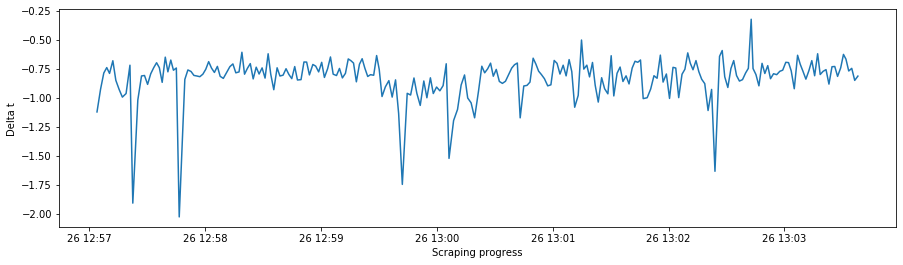

In [6]:
# Plot the time it took to make the call

plt.figure(figsize=(15,4))
plt.plot(log_df.dt,log_df.delta_t)
plt.ylabel('Delta t')
plt.xlabel('Scraping progress')

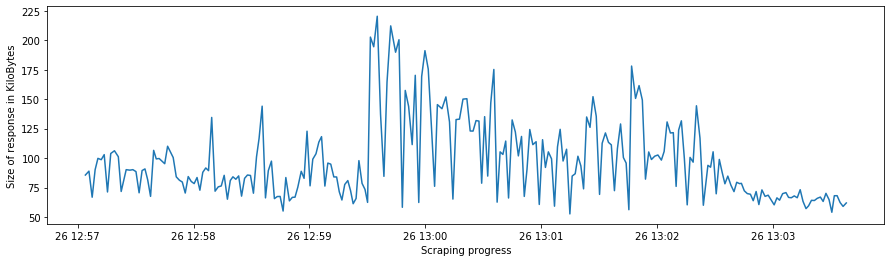

In [7]:
# Plot the response size over time.
plt.figure(figsize=(15,4))
plt.ylabel('Size of response in KiloBytes')
plt.xlabel('Scraping progress')
plt.plot(log_df.dt,log_df.response_size/1000)

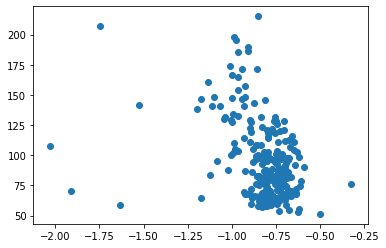

In [9]:
# Plot the delta_t against the response_size. These two should correlate pretty well.
plt.scatter(log_df.delta_t,log_df.response_size/1024)

In [10]:
# -> no clear correlation visible in this case, which might be since download size is not very big

## Investigate errors
log_df.success.value_counts() ## Count errors

print(log_df.success.value_counts())

# -> no errors, all 250 downloads (all True) passed through successfully

## Groupby time
# round the time for aggregation
log_df['dt_minute'] = log_df.dt.apply(lambda x: x-datetime.timedelta(seconds=x.second,microseconds=x.microsecond))
log_df['dt_hour'] = log_df.dt.apply(lambda x: x-datetime.timedelta(minutes=x.minute,seconds=x.second,microseconds=x.microsecond))

print(log_df.groupby('dt_hour').success.mean())

True    250
Name: success, dtype: int64
dt_hour
2019-08-26 12:00:00.000000006    True
2019-08-26 12:00:00.000000020    True
2019-08-26 12:00:00.000000044    True
2019-08-26 12:00:00.000000049    True
2019-08-26 12:00:00.000000057    True
2019-08-26 12:00:00.000000074    True
2019-08-26 12:00:00.000000100    True
2019-08-26 12:00:00.000000102    True
2019-08-26 12:00:00.000000103    True
2019-08-26 12:00:00.000000106    True
2019-08-26 12:00:00.000000112    True
2019-08-26 12:00:00.000000114    True
2019-08-26 12:00:00.000000117    True
2019-08-26 12:00:00.000000123    True
2019-08-26 12:00:00.000000124    True
2019-08-26 12:00:00.000000127    True
2019-08-26 12:00:00.000000163    True
2019-08-26 12:00:00.000000165    True
2019-08-26 12:00:00.000000181    True
2019-08-26 12:00:00.000000199    True
2019-08-26 12:00:00.000000205    True
2019-08-26 12:00:00.000000227    True
2019-08-26 12:00:00.000000234    True
2019-08-26 12:00:00.000000245    True
2019-08-26 12:00:00.000000282    True
20